##  Régression avec un réseau de neurones profonds (DNN)

In [1]:
# chargement des bibliotheques .......

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)


2.6.0


## Collecter et prétraiter les données¶

La première étape consiste à collecter et prétraiter les données appropriées pour garantir qu'elles sont dans un format que le réseau neuronal peut utiliser. Cela peut impliquer le nettoyage des données, la gestion des valeurs manquantes et la normalisation des données. 

In [63]:
# chargement du dataframe avec conversion decimal des virgules par des point...............


dataset = pd.read_csv('forestfires.csv', delimiter=",", decimal=",")
dataset.head()


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0,0
3,8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0,0


In [64]:
# L'ensemble de données contient des lectures enregistrées par les capteurs chimiques
# pour plusieurs substances présentes dans l'air. 

# libelé de chaque colonnes dans l'ordre indiqué : 

# 0 X - Coordonnées spatiales sur l'axe X sur la carte du parc Montesinho : 1 à 9
# 1 Y - Coordonnées spatiales sur l'axe y sur la carte du parc de Montesinho : 2 à 9
# 2 mois - mois de l'année : "jan" à "dec"
# 3  jour - jour de la semaine : « lundi » à « soleil »
# 4 FFMC - Indice FFMC du système FWI : 18,7 à 96,20
# 5 DMC - Indice DMC du système FWI : 1,1 à 291,3
# 6 Indice DC - DC du système FWI : 7,9 à 860,6
# 7 ISI - Indice ISI du système FWI : 0,0 à 56,10
# 8 temp - température en degrés Celsius : 2,2 à 33,30
# 9 HR - humidité relative en % : 15,0 à 100
# 10 vent - vitesse du vent en km/h : 0,40 à 9,40
# 11 pluie extérieure en mm/m2 : 0,0 à 6,4
# 12 superficie - la superficie brûlée de la forêt (en ha) : 0,00 à 1



# Cortez,Paulo and Morais,Anbal. (2008). 
# Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.


In [65]:
# nombre de lignes et de colonnes

dataset.shape

(517, 13)

In [74]:
# Pour voir le type de données de chaque colonne. 

dataset.dtypes

X       float64
Y       float64
FFMC    float64
DMC     float64
DC      float64
ISI     float64
temp    float64
RH      float64
wind    float64
rain    float64
area    float64
dtype: object

In [73]:
# pour transformer toutes les colonnes.........

dataset=dataset.apply(pd.to_numeric)

In [69]:
# pour convertir int en float............

dataset['RH'] = dataset['RH'].astype(float)
dataset['Y'] = dataset['Y'].astype(float)
dataset['X'] = dataset['X'].astype(float)


In [70]:
# suppression des colonnes inutiles............

dataset=dataset.drop(['month','day'], axis=1)

In [53]:
# pour visualiser les lignes NaN................

dataset.isnull().sum()

X       0
Y       0
FFMC    0
DMC     0
DC      0
ISI     0
temp    0
RH      0
wind    0
rain    0
area    0
dtype: int64

In [7]:
# pour supprimer les NaN..............

dataset=dataset.dropna()

In [76]:
# pour visualiser les lignes NaN................

dataset.isnull().sum()

X       0
Y       0
FFMC    0
DMC     0
DC      0
ISI     0
temp    0
RH      0
wind    0
rain    0
area    0
dtype: int64

In [75]:
# pour verifier suppression..........

dataset.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7.0,5.0,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,0.0
1,7.0,4.0,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7.0,4.0,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,0.0
3,8.0,6.0,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8.0,6.0,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,0.0


In [77]:
# divisions les données en un ensembles d'entrainement et de test...............

# utilisation de l'ensemble des données de test pour l'évaluation finale.........

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print('Nombre de lignes l entrainement',train_dataset.shape)
print('Nombre de lignes pour les test', test_dataset.shape)

Nombre de lignes l entrainement (414, 11)
Nombre de lignes pour les test (103, 11)


In [78]:
# séparation  les entités des étiquettes...........
# séparation de la valeur cible des caractéristiques ( features )..........
# c'est cette cible que le modele va devoir prédire.

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('temp') # la cible est la Température 
test_labels = test_features.pop('temp') # la cible est la Température

Dans l'analyse de régression utilisant un DNN, l'objectif est d'apprendre une fonction qui mappe les caractéristiques d'entrée à la sortie, de sorte que les prédictions faites par le modèle soient aussi précises que possible. Les caractéristiques d'entrée passent par la couche d'entrée du DNN puis sont traitées par les couches cachées, qui utilisent des fonctions d'activation non linéaires pour apprendre les relations complexes dans les données. La couche de sortie du DNN produit une prédiction pour la variable dépendante basée sur les caractéristiques d'entrée traitées

## Définir l'architecture du mdele

L'étape suivante consiste à définir l'architecture du réseau de neurones. Cela inclut la sélection du type de couches (couches denses ou convolutives), du nombre de neurones dans chaque couche et des fonctions d'activation à utiliser.


## Compiler le modele

Une fois l'architecture définie, il faut compiler le modèle. Cela implique de spécifier la fonction de perte, l'optimiseur et toutes les métriques que nous utiliserons pour évaluer le modèle.


In [79]:
# normalisation les données avec (tf.keras.layers.Normalization)...........


normalizer = tf.keras.layers.Normalization(axis=-1)

In [80]:
normalizer.adapt(np.array(train_features))

2023-11-28 23:10:30.767583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [81]:
#  Régression avec un réseau de neurones profond (DNN)..........
# modèles DNN à entrées multiples.


def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),# 2 couches Dense avec fonction activation relu
      layers.Dense(64, activation='relu'),
      layers.Dense(1) # une couche Dense linéaire à sortie unique
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model


In [82]:
# Régression utilisant un DNN et plusieurs entrées

# Répétez le processus précédent en utilisant toutes les entrées.
# Les performances du modèle s'améliorent légèrement sur l'ensemble de données de validation.

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [83]:
# fonction d affichage....

def plot_loss(history):
  plt.plot(history.history['loss'], label='MAE')
  plt.plot(history.history['val_loss'], label='val_MAE')
  plt.ylim([0, 15])
  plt.xlabel('Epoch')
  plt.ylabel('Erreur en $ [T]')
  plt.legend()
  plt.grid(True)

## Entrainer le modele

L'étape suivante consiste à entraîner le modèle à l'aide des données prétraitées. Cela implique d'introduire les données dans le modèle et d'ajuster les poids et les biais des neurones du réseau pour minimiser la fonction de perte.


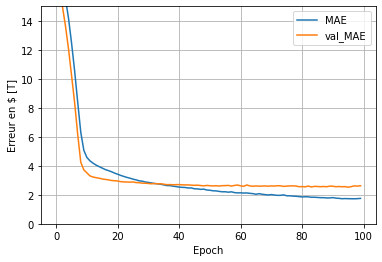

In [84]:
# entrainement ....................

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


plot_loss(history)

## Evaluer le modele

Une fois le modèle entraîné, il doit être évalué pour déterminer ses performances. Cela peut impliquer l'utilisation d'un ensemble de données distinct (ou d'un sous-ensemble des données d'entraînement) pour évaluer la capacité du modèle à effectuer des prédictions précises.


In [85]:
# résultats de la MAE sur l'ensemble de test :

test_resultats = {}

test_resultats['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_resultats

{'dnn_model': 2.5887606143951416}

## Faire des prédiction

Une fois le modèle affiné, nous pouvons l'utiliser pour prédire de nouvelles données.


In [87]:
#  prédiction...

y_pred = dnn_model.predict(test_features)
print('prédiction de la Température ',y_pred[1:5])
print('Température  attendue',test_labels[1:5])

prédiction de la Température  [[14.251]
 [27.758]
 [12.793]
 [20.375]]
Température  attendue 25    16.3
28    30.2
31    11.2
32    20.6
Name: temp, dtype: float64


In [88]:
y_pred[1:5]

array([[14.251],
       [27.758],
       [12.793],
       [20.375]], dtype=float32)

In [89]:
test_labels[1:5]

25    16.3
28    30.2
31    11.2
32    20.6
Name: temp, dtype: float64